# Setup

In [1]:
import json
import os
import sys

sys.path.append('..')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from utils import read_csv_non_utf, extract_year, ratios_to_DI_cats

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']
ferreiro_arias2024 = config['indiv_data_paths']['ferreiro_arias2024']

ben_lop_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)
fer_ari_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, ferreiro_arias2024)

In [10]:
# Choosing the dataset to explore - "mammals" or "birds"
dataset = 'both'

# Reading in the dataset
if dataset == 'birds':
    data = pd.read_csv(fer_ari_path)
elif dataset == 'mammals':
    data = read_csv_non_utf(ben_lop_path)
elif dataset == 'both':
    ben_lop2019 = read_csv_non_utf(ben_lop_path)
    fer_ari2024 = pd.read_csv(fer_ari_path)

    cols = ['Order', 'Family', 'Species', 'ratio', 'X', 'Y', 'Country']
    ben_lop2019 = ben_lop2019[cols]
    ben_lop2019['Class'] = 'Mammalia'

    cols = ['Order', 'Family', 'Species', 'RR', 'Latitude', 'Longitude', 'Country']
    fer_ari2024 = fer_ari2024[cols]
    fer_ari2024['Class'] = 'Aves'
    fer_ari2024 = fer_ari2024.rename(columns = {'RR' : 'ratio', 'Longitude' : 'X', 'Latitude' : 'Y'})

    data = pd.concat((ben_lop2019, fer_ari2024), axis = 0)

data.head()

,Order,Family,Species,ratio,X,Y,Country,Class
0,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.377193,9.839,-1.916,Gabon,Mammalia
1,Proboscidea,Elephantidae,Loxodonta africana,0.865690,9.839,-1.916,Gabon,Mammalia
2,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.833333,9.839,-1.916,Gabon,Mammalia
3,Proboscidea,Elephantidae,Loxodonta africana,0.900862,9.839,-1.916,Gabon,Mammalia
4,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.956140,9.839,-1.916,Gabon,Mammalia


In [11]:
data['Class'].value_counts()

Class
Mammalia    3281
Aves        1484
Name: count, dtype: int64

In [13]:
(3281-1484)/1484 * 100

121.09164420485175

# Reading and exploring the dataset

In [5]:
# Checking basic info
num_species = len(data['Species'].unique())
print(f'{num_species} species')

print(f'{len(data)} effect sizes')

if dataset != 'both':
    num_studies = len(data['Study'].unique())
    print(f'{num_studies} studies')

518 species
1484 effect sizes
55 studies


## Exploring taxonomic representation

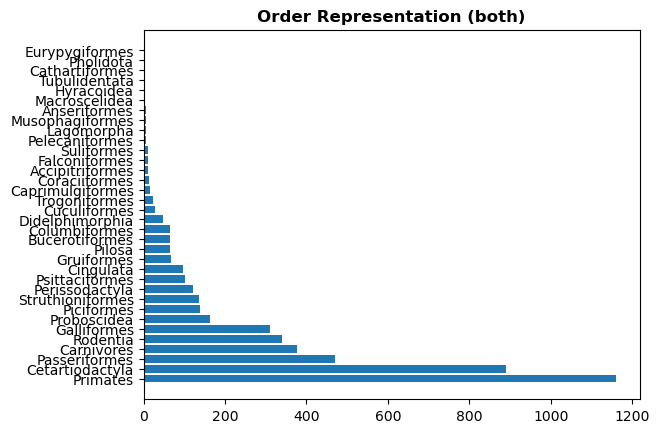

In [5]:
order_counts = data['Order'].value_counts()

plt.barh(order_counts.index, order_counts.values)
plt.title(f'Order Representation ({dataset})', weight = 'bold');

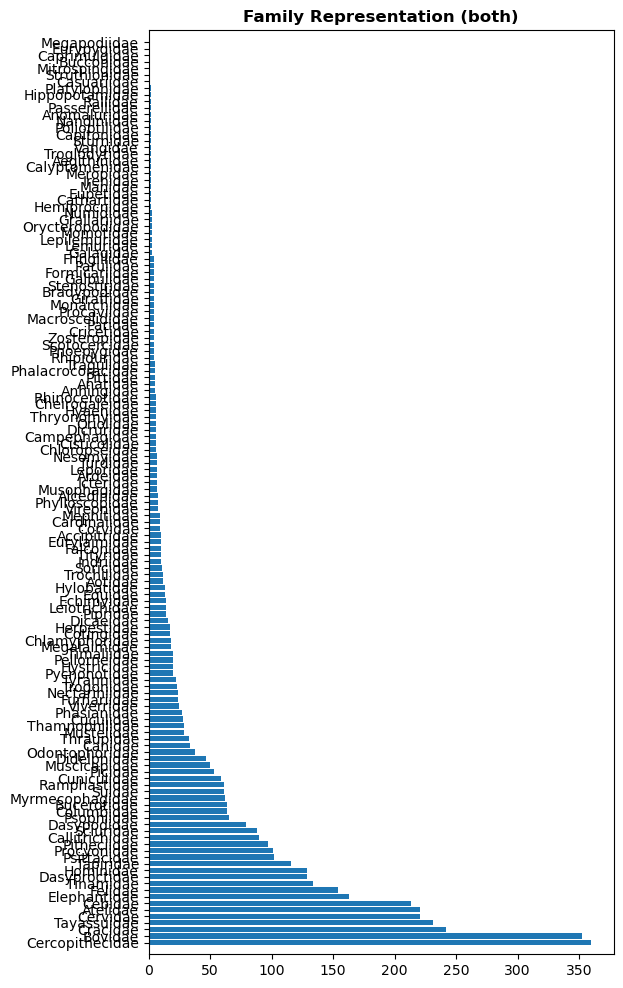

In [6]:
fam_counts = data['Family'].value_counts()

plt.figure(figsize = (6, 12))

plt.barh(fam_counts.index, fam_counts.values)
plt.title(f'Family Representation ({dataset})', weight = 'bold')

plt.margins(y = 0.01);

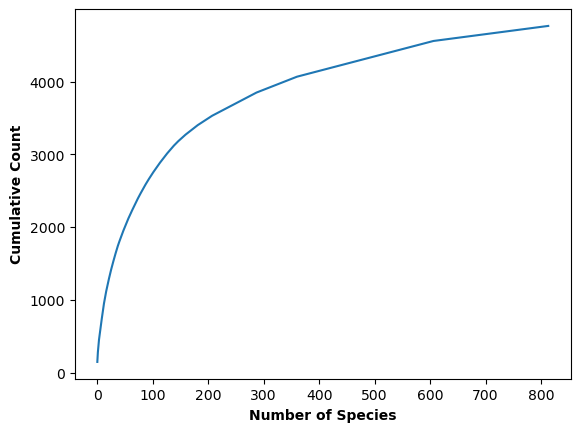

In [7]:
species_counts = data['Species'].value_counts()
species_cumsum = species_counts.to_numpy().cumsum()

plt.plot(species_cumsum)

plt.ylabel('Cumulative Count', weight = 'bold')
plt.xlabel('Number of Species', weight = 'bold');

## Exploring spatial representation

In [8]:
if dataset != 'both':
    col = 'Region' if dataset == 'mammals' else 'Realm'
    region_counts = data[col].value_counts()
    
    plt.barh(region_counts.index, region_counts)
    plt.xlabel('Number of Effect Sizes', weight = 'bold');

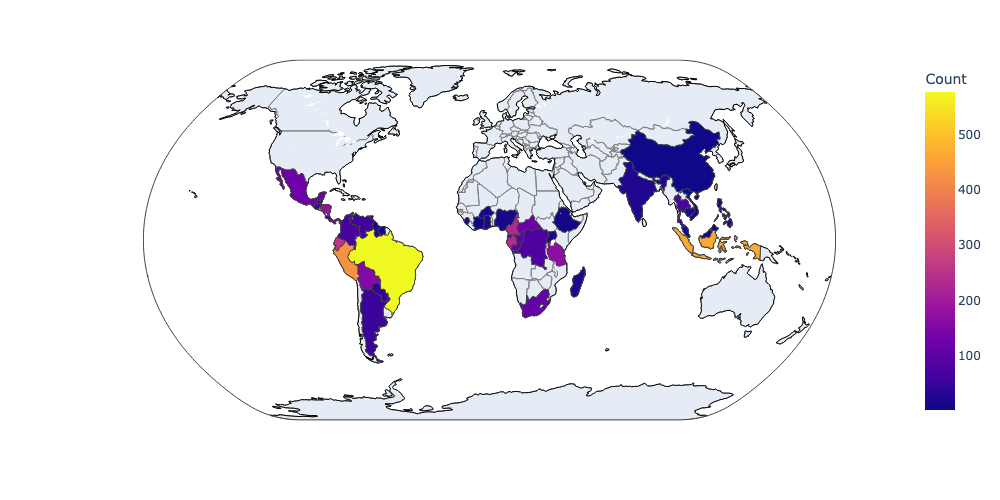

In [10]:
# Plotting distribution of effect sizes across countries
country_counts = data['Country'].value_counts().to_frame().reset_index()

fig = px.choropleth(country_counts, 
                    locations = 'Country',
                    locationmode = 'country names',
                    color = 'count', 
                    hover_name = 'Country', 
                    color_continuous_scale = px.colors.sequential.Plasma, 
                    width = 1000,
                    height = 500, 
                    labels = {'count' : 'Count'})
fig.update_geos(showcoastlines = True, coastlinecolor = 'Black',
                showcountries = True, countrycolor = 'Grey',
                projection_type = 'natural earth')

fig.show()

dpi = 200
fig.write_image('../figures/effect_sizes_countries.png', width = 6 * dpi, height = 3 * dpi, scale = 1)

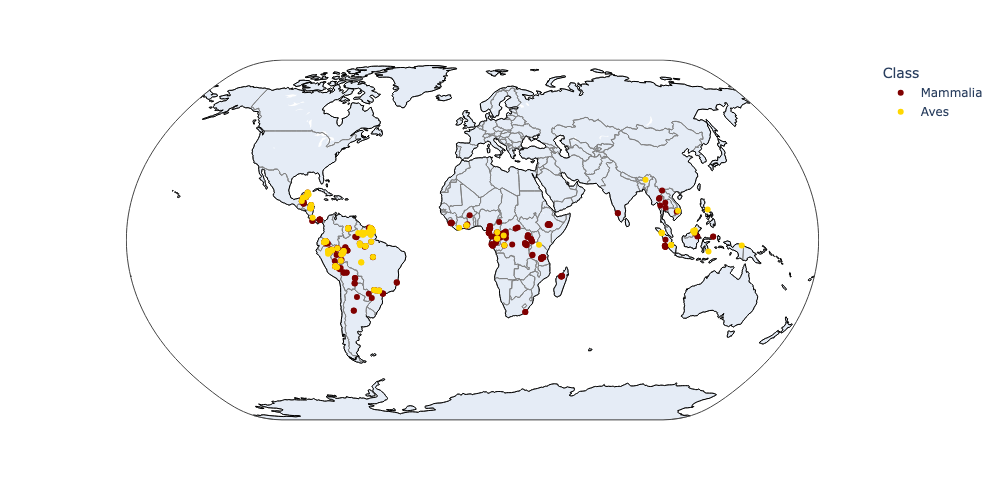

In [19]:
# Plotting study locations as a scatterplot
lat = 'Y' if dataset in ['mammals', 'both'] else 'Latitude'
lon = 'X' if dataset in ['mammals', 'both'] else 'Longitude'
data_unique = data.drop_duplicates(subset = [lat, lon, 'Class'])

fig = px.scatter_geo(data_unique, lat = lat, lon = lon, color = 'Class',
                     color_discrete_sequence = ['maroon', 'gold'], 
                     width = 1000, height = 500)
fig.update_geos(showcoastlines = True, coastlinecolor = 'Black',
                showcountries = True, countrycolor = 'Grey',
                projection_type = 'natural earth')
fig.update_layout(showlegend = True, geo = {'projection_scale' : 1})

fig.show()

dpi = 200
fig.write_image('../figures/study_sites.png', width = 6 * dpi, height = 3 * dpi, scale = 1)

## Inspecting response variable

In [6]:
# Checking number of extirpation events in the dataset
resp_col = 'ratio' if dataset in ['mammals', 'both'] else 'RR'
num_non_extirp = (data[resp_col] != 0).sum()
num_extirp = len(data) - num_non_extirp

print(f'{num_extirp} extirpation events ({round(num_extirp / len(data) * 100, 2)}%), {num_non_extirp} non-extirpation events ({round(num_non_extirp / len(data) * 100, 2)}%)')

199 extirpation events (13.41%), 1285 non-extirpation events (86.59%)


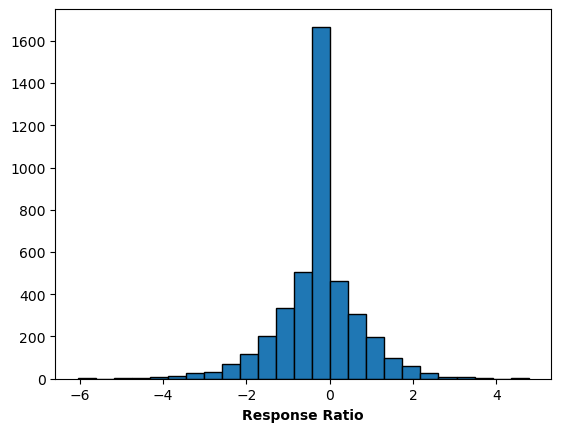

In [99]:
# Plotting a histogram of response ratio
plt.hist(np.log(data[data[resp_col] != 0][resp_col]), bins = 25, edgecolor = 'black')

plt.xlabel('Response Ratio', weight = 'bold');

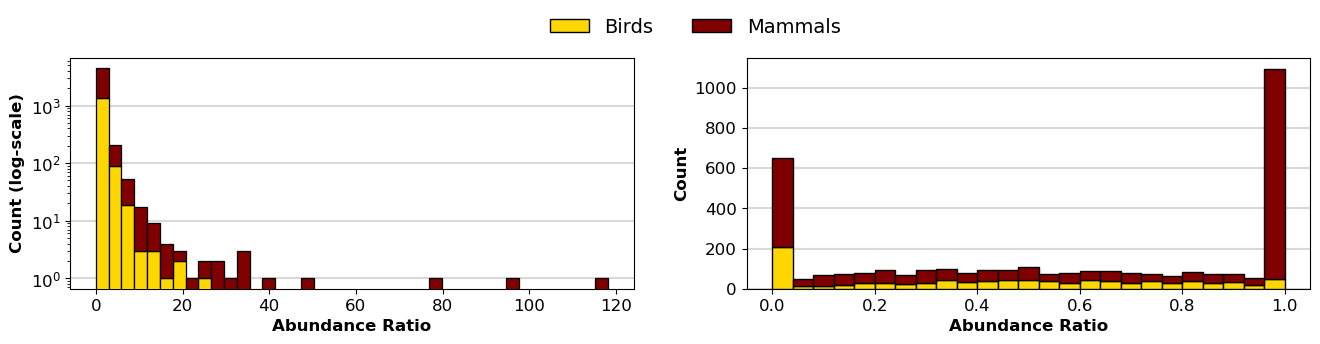

In [83]:
# Plotting distribution of abundance ratios...
fig, axs = plt.subplots(1, 2, figsize = (16, 3))
palette = ['maroon', 'gold']

#  plotting a histogram of actual abundance ratios (hunted to unhunted)
sns.histplot(data = data, stat = 'count', multiple = 'stack', x = resp_col, kde = False, alpha = 1,
             hue = 'Class' if dataset == 'both' else None, legend = False, bins = 40, palette = palette,
             zorder = 100, ax = axs[0])

axs[0].set_yscale('log')

label_size = 12
axs[0].set_xlabel('Abundance Ratio', weight = 'bold', size = label_size)
axs[0].set_ylabel('Count (log-scale)', weight = 'bold', size = label_size)

axs[0].tick_params(axis = 'both', which = 'major', labelsize = label_size)

axs[0].grid(visible = True, which = 'major', axis = 'y', color = 'grey', zorder = 0, linewidth = 1.5,
            alpha = 0.3)

#  plotting the distribution of abundance ratios for values between 0 and 1
masked_data = data[(data[resp_col] <= 1) & (data[resp_col] >= 0)]

sns.histplot(data = masked_data, stat = 'count', multiple = 'stack', x = resp_col, kde = False, alpha = 1,
             hue = 'Class' if dataset == 'both' else None, legend = False, bins = 25, palette = palette,
             zorder = 100, ax = axs[1])

label_size = 12
axs[1].set_xlabel('Abundance Ratio', weight = 'bold', size = label_size)
axs[1].set_ylabel('Count', weight = 'bold', size = label_size)

axs[1].tick_params(axis = 'both', which = 'major', labelsize = label_size)

axs[1].grid(visible = True, which = 'major', axis = 'y', color = 'grey', zorder = 0, linewidth = 1.5,
            alpha = 0.3)

axs[1].legend(loc = 'upper left', labels = ['Birds', 'Mammals'], frameon = False, prop = {'size' : label_size + 2},
              bbox_to_anchor = (-0.38, 1.25), ncols = 2);
# plt.savefig(f'../Figures/abundance_ratios_distributions_{dataset}.pdf', bbox_inches = 'tight');

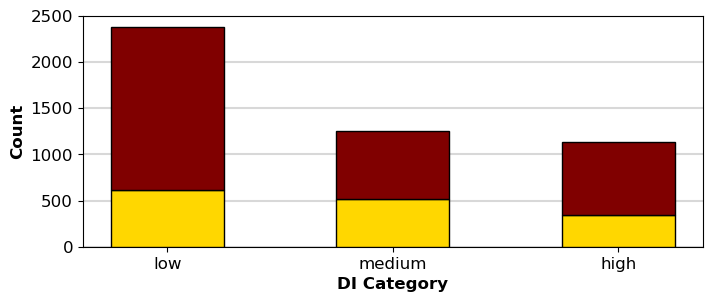

In [133]:
# Plotting the distribution of DI categories
labelsize = 12

data['DI_cat'] = pd.Categorical(ratios_to_DI_cats(data[resp_col], category_names = True), 
                                categories = ['low', 'medium', 'high'])

plt.figure(figsize = (8, 3))
sns.histplot(data, x = 'DI_cat', hue = 'Class' if dataset == 'both' else None, multiple = 'stack',
             palette = palette, legend = False, shrink = 0.5, alpha = 1, zorder = 100)

# plt.legend(labels = ['Birds', 'Mammals'], frameon = False, loc = 'upper right' , bbox_to_anchor = (1, 1.03))
plt.grid(visible = True, which = 'major', axis = 'y', color = 'grey', zorder = 0, linewidth = 1.5, alpha = 0.3)

plt.xlabel('DI Category', weight = 'bold', size = labelsize)
plt.ylabel('Count', weight = 'bold', size = labelsize)

plt.tick_params(axis = 'both', which = 'major', labelsize = label_size)

plt.savefig(f'../figures/DI_category_distribution_{dataset}.pdf', bbox_inches = 'tight')
plt.show()

In [102]:
def four_DI_cats(ratios, neighborhood = 0):
    new_ratios = np.zeros_like(ratios).astype(str)
    
    new_ratios[ratios <= 0 + neighborhood] = 'extirpated'
    new_ratios[(ratios > 0 + neighborhood) & (ratios < 1 - neighborhood)] = 'decline'
    new_ratios[(ratios >= 1 - neighborhood) & (ratios <= 1 + neighborhood)] = 'no change'
    new_ratios[ratios > 1 + neighborhood] = 'increase'

    return new_ratios

In [103]:
# Taking a look at different possible tolerances for extirpation/no change
nbrs = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]

for nbr in nbrs:
    print(f'NEIGHBORHOOD: {nbr}')
    print('-----------------')
    print(pd.Series(four_DI_cats(data[resp_col], neighborhood = nbr)).value_counts())
    print()

NEIGHBORHOOD: 0
-----------------
decline       1929
increase      1188
no change     1041
extirpated     607
Name: count, dtype: int64

NEIGHBORHOOD: 0.01
-----------------
decline       1917
increase      1177
no change     1057
extirpated     614
Name: count, dtype: int64

NEIGHBORHOOD: 0.02
-----------------
decline       1889
increase      1166
no change     1086
extirpated     624
Name: count, dtype: int64

NEIGHBORHOOD: 0.03
-----------------
decline       1868
increase      1154
no change     1111
extirpated     632
Name: count, dtype: int64

NEIGHBORHOOD: 0.04
-----------------
decline       1833
no change     1143
increase      1140
extirpated     649
Name: count, dtype: int64

NEIGHBORHOOD: 0.05
-----------------
decline       1802
no change     1172
increase      1127
extirpated     664
Name: count, dtype: int64

NEIGHBORHOOD: 0.1
-----------------
decline       1649
no change     1320
increase      1061
extirpated     735
Name: count, dtype: int64



## Taking a look at study years

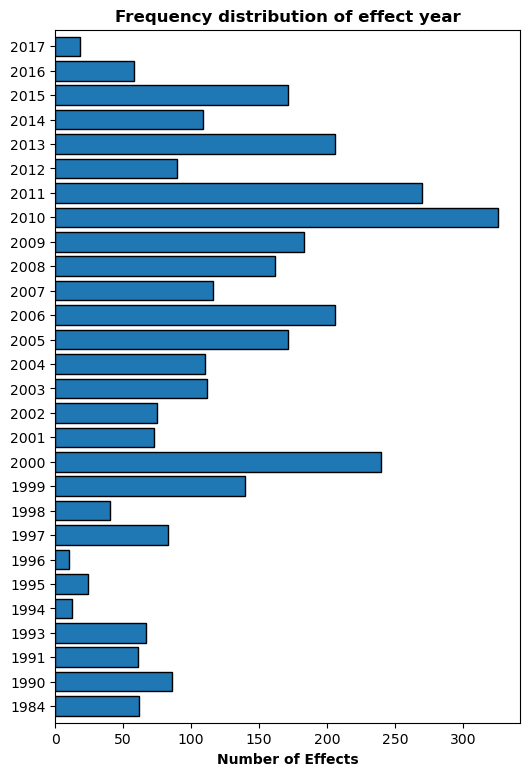

In [58]:
# By effect size
if dataset == 'mammals':
    effect_year_counts = data['Reference'].apply(extract_year).value_counts().sort_index()
    
    plt.figure(figsize = (6, 9))
    plt.barh(effect_year_counts.index.astype(str), effect_year_counts, edgecolor = 'black')
    plt.margins(y = 0.01)
    
    plt.title('Frequency distribution of effect year', weight = 'bold')
    plt.xlabel('Number of Effects', weight = 'bold');
else:
    print('Ferreiro-Arias et al. (2024) doesn\'t provide study years.')

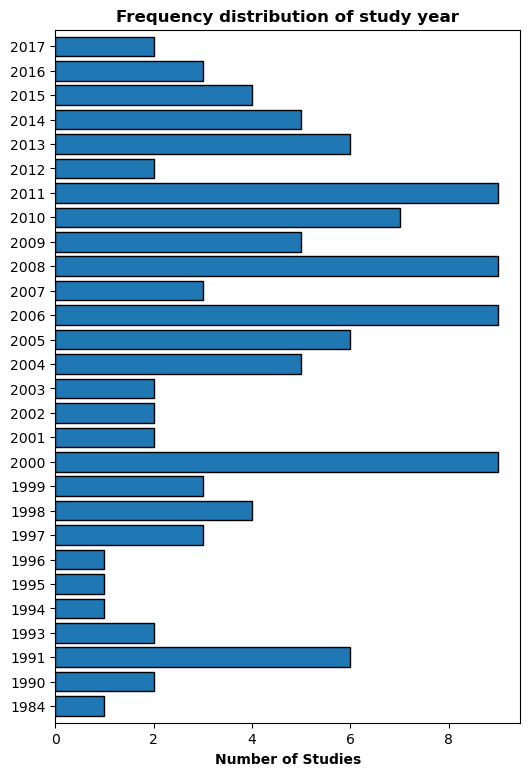

In [60]:
# By studies sizes
if dataset == 'mammals':
    study_year = pd.Series([extract_year(ref) for ref in data['Reference'].unique()])
    study_year_counts = study_year.value_counts().sort_index()
    
    plt.figure(figsize = (6, 9))
    plt.barh(study_year_counts.index.astype(str), study_year_counts, edgecolor = 'black')
    plt.margins(y = 0.01)
    
    plt.title('Frequency distribution of study year', weight = 'bold')
    plt.xlabel('Number of Studies', weight = 'bold');
else:
    print('Ferreiro-Arias et al. (2024) doesn\'t provide study years.')